In [1]:
import sklearn
import numpy as np
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,core
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D,Conv1D, MaxPooling2D
from keras import optimizers, applications
from keras.applications import Xception
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

Using TensorFlow backend.


In [28]:
def regenModel(i = 8):
    model = Sequential()
    model.add(Dense(80, activation = 'relu', input_shape = (i,)))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    # Let's train the model using RMSprop
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',#keras.optimizers.sgd(lr=0.0001,momentum = 0.7,nesterov=True),
                  metrics=['accuracy'])
    return model

In [29]:
lines = [line.rstrip('\n').split(',') for line in open('Data.txt')]
lines = np.asarray(lines)
X = lines[:,:-1]
Y = lines[:,-1]
X = X.astype(np.float64)
Y = Y.astype(np.float64)

In [30]:
np.random.seed(42)
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
#kf.get_n_splits(X)
print(kf)  
ind=0
eigen_fa = []
retained_var_list = []
for i in range(1,9):
    fold_acc = 0
    retained_var = []
    print('Number of Eigenvectors: ', i)
    for train_index, test_index in kf.split(X):
        #print('\nFOLD: ', ind)
        ind+=1
        model = regenModel(i)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        x_mean = np.mean(X_train,axis=0)
        X_train-=x_mean
        X_test -=x_mean
        cov = np.dot(X_train.T, X_train)/ X_train.shape[0] # get the data covariance matrix
        U,S,V = np.linalg.svd(cov) #U = eigenvectors, S = eigenvalues
        X_train = np.dot(X_train, U[:,:i])
        X_test = np.dot(X_test, U[:,:i])
        model.fit(X_train, y_train,
              batch_size=128,
              epochs=100,
              validation_data=(X_test, y_test),
              shuffle=True,verbose = 0)
        eva = model.evaluate(X_test, y_test, batch_size=64,verbose = 0)
        eva = np.asarray(eva)
        fold_acc += (eva[1]/5)
        retained_var.append((np.sum(S[:i]) / np.sum(S)))
        #print(eva)
    print(fold_acc)
    eigen_fa.append(fold_acc)
    retained_var_list.append(retained_var)


KFold(n_splits=5, random_state=None, shuffle=False)
Number of Eigenvectors:  1
0.65244885746
Number of Eigenvectors:  2
0.740964265638
Number of Eigenvectors:  3
0.747440799832
Number of Eigenvectors:  4
0.748790428509
Number of Eigenvectors:  5
0.740964265956
Number of Eigenvectors:  6
0.769569648505
Number of Eigenvectors:  7
0.742279945209
Number of Eigenvectors:  8
0.754019185587


8


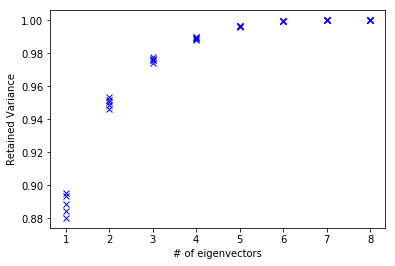

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
print(len(retained_var_list))
plt.xlabel('# of eigenvectors')
plt.ylabel('Retained Variance')
for i in range (1,9):
    plt.plot([i,i,i,i,i], retained_var_list[i-1][:], 'bx')

[0.65244885745998471, 0.74096426563810969, 0.74744079983221245, 0.74879042850914024, 0.7409642659558392, 0.76956964850516785, 0.74227994520932761, 0.75401918558725911]


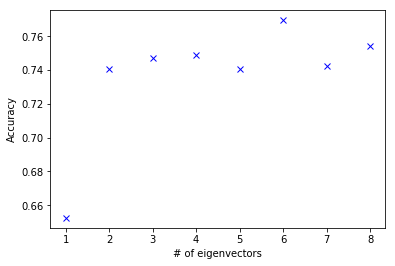

In [32]:
print(eigen_fa)
plt.xlabel('# of eigenvectors')
plt.ylabel('Accuracy')
plt.plot(range(1,9),eigen_fa, 'bx')

In [35]:
np.random.seed(42)
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
#kf.get_n_splits(X)
print(kf)  
ind=0
fold_acc = []
print(model.metrics_names)
for train_index, test_index in kf.split(X):
    print('\nFOLD: ', ind)
    ind+=1
    model = regenModel()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model.fit(X_train, y_train,
          batch_size=128,
          epochs=50,
          validation_data=(X_test, y_test),
          shuffle=True,verbose = 0)
    eva = model.evaluate(X_test, y_test, batch_size=64,verbose = 0)
    fold_acc.append(eva[1])
    print(eva)


KFold(n_splits=5, random_state=None, shuffle=False)
['loss', 'acc']

FOLD:  0
[0.50459222901951184, 0.75324675943944364]

FOLD:  1
[0.54456647495170696, 0.68831169760072386]

FOLD:  2
[0.48454031619158661, 0.75324675556901211]

FOLD:  3
[0.40996835784974439, 0.82352940825855026]

FOLD:  4
[0.52818261758953922, 0.72549019374099433]


[ 0.75324676  0.6883117   0.75324676  0.82352941  0.72549019]


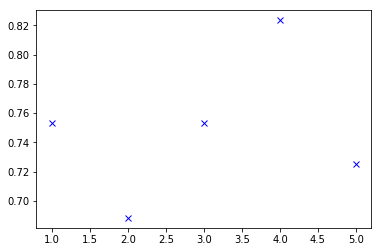

In [36]:
f_a  = np.asarray(fold_acc)
print(f_a)
plt.plot(range(1,6), f_a, 'bx')

In [37]:
np.mean(f_a)

0.74876496292174488